### Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter
from scipy.optimize import minimize

### Introduction

Consider a company with a subscription-based business model. 1000 customers are acquired at the beginning of Year 1 with the following renewal patterns:
| ID   | Year 1 | Year 2 | Year 3 | Year 5 | Year 5 |
| ---- | ------ | ------ | ------ | ------ | ------ |
| 1    | 1      | 1      | 0      | 0      | 0      |
| 2    | 1      | 0      | 0      | 0      | 0      |
| 3    | 1      | 1      | 1      | 0      | 0      |
| 4    | 1      | 1      | 0      | 0      | 0      |
| 5    | 1      | 1      | 1      | 1      | 1      |
| .    | .      | .      | .      | .      | .      |
| .    | .      | .      | .      | .      | .      |
| .    | .      | .      | .      | .      | .      |
| 998  | 1      | 0      | 0      | 0      | 0      |
| 999  | 1      | 1      | 1      | 0      | 0      |
| 1000 | 1      | 0      | 0      | 0      | 0      |
|      | **1000**   | **631**    | **468**    | **382**    | **326**    |

- How many customers will “survive” to Year 6, 7, . . . , 13? 
- What will the retention rates for this cohort look like for the next 8 years?

<div>
<img src="references/timeline.png" width="600"/>
</div>

The **survivor function** $S(t)$ is the proportion of the cohort that continue as a customer beyond $t$.
$$S(0) = ?$$
$$S(1) = ?$$
$$S(2) = ?$$

The **retention rate** is the ratio of customers retained to the number at risk.
$$r(1) = ?$$
$$r(2) = ?$$

For survivor function $S(t)$
$$r(t) = \frac{S(t)}{S(t − 1)}$$

**Modeling Objective**: We want to derive a mathematical expression for $S(t)$, which can then be used to generate the desired forecasts.

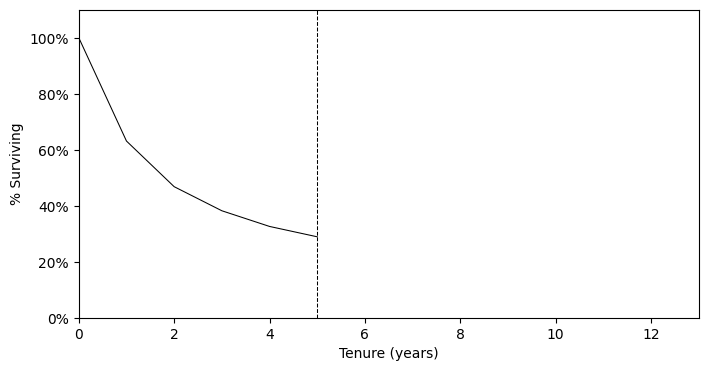

In [2]:
year, alive = np.loadtxt('data/hardie-sample-retention.csv', dtype='object', delimiter=',', unpack=True, skiprows=1) 
year = year.astype(int)
alive = alive.astype(float)

train_marker_x = [5 for _ in np.arange(0,1.2,0.1)]
train_marker_y = [_ for _ in np.arange(0,1.2,0.1)]

surviving = alive / alive[0]

plt.figure(figsize=(8,4), dpi=100)
plt.plot(surviving[:6], "k-", linewidth=0.75)
plt.plot(train_marker_x, train_marker_y, "k--", linewidth=0.75)
plt.xlabel("Tenure (years)")
plt.ylabel("% Surviving")
plt.ylim(0,1.1)
plt.xlim(0, 13)
plt.gca().yaxis.set_major_formatter(PercentFormatter(1))

#### Projecting Survival Using Simple Functions of Time

In [3]:
import statsmodels.api as sm
import warnings
warnings.simplefilter('ignore', category=UserWarning)

y = surviving[:5]

# Linear Function Regression
x = sm.add_constant(year[:5])   
linear_results = sm.OLS(y, x).fit()
print(linear_results.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.869
Model:                            OLS   Adj. R-squared:                  0.825
Method:                 Least Squares   F-statistic:                     19.88
Date:                Mon, 11 Nov 2024   Prob (F-statistic):             0.0210
Time:                        17:25:48   Log-Likelihood:                 5.0720
No. Observations:                   5   AIC:                            -6.144
Df Residuals:                       3   BIC:                            -6.925
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.8808      0.088     10.038      0.0

In [4]:
# Quadratic Function Regression
x = np.column_stack((year[:5], year[:5]**2))
x = sm.add_constant(x)
quadratic_results = sm.OLS(y, x).fit()
print(quadratic_results.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.989
Model:                            OLS   Adj. R-squared:                  0.978
Method:                 Least Squares   F-statistic:                     90.91
Date:                Mon, 11 Nov 2024   Prob (F-statistic):             0.0109
Time:                        17:25:48   Log-Likelihood:                 11.295
No. Observations:                   5   AIC:                            -16.59
Df Residuals:                       2   BIC:                            -17.76
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.9812      0.038     26.091      0.0

In [5]:
# Exponential Function Regression
x = year[:5]
x = sm.add_constant(x)
exponential_results = sm.OLS(np.log(surviving[:5]), x).fit()
print(exponential_results.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.954
Model:                            OLS   Adj. R-squared:                  0.939
Method:                 Least Squares   F-statistic:                     62.14
Date:                Mon, 11 Nov 2024   Prob (F-statistic):            0.00425
Time:                        17:25:48   Log-Likelihood:                 5.2161
No. Observations:                   5   AIC:                            -6.432
Df Residuals:                       3   BIC:                            -7.213
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.1119      0.085     -1.312      0.2

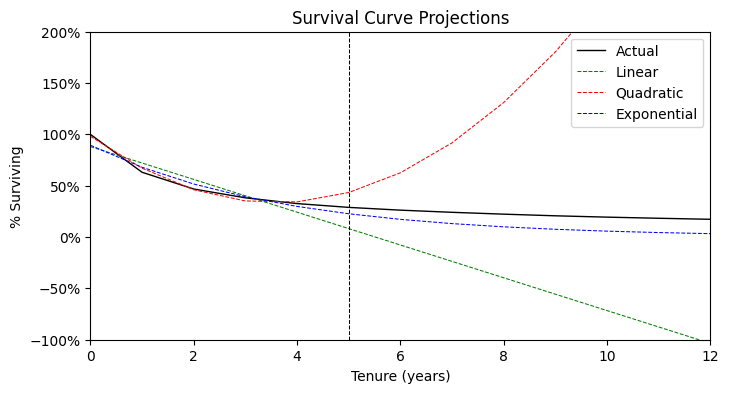

In [28]:
intercept, t_coeff = linear_results.params
y_lin = intercept + (t_coeff * year)
intercept, t_coeff, tsquare = quadratic_results.params
y_quad = intercept + t_coeff*year + tsquare*year**2
intercept, t_coeff = exponential_results.params
y_exp = np.exp(intercept + t_coeff*year)

train_marker_x = [5 for _ in np.arange(-1,2.1,0.1)]
train_marker_y = [_ for _ in np.arange(-1,2.1,0.1)]

surviving = alive / alive[0]

plt.figure(figsize=(8,4), dpi=100)
plt.title("Survival Curve Projections")
plt.plot(year, surviving, "k-", linewidth=1, label="Actual")
plt.plot(year, y_lin, "g--", linewidth=0.75, label="Linear")
plt.plot(year, y_quad, "r--", linewidth=0.75, label="Quadratic")
plt.plot(year, y_exp, "b--", linewidth=0.75, label="Exponential")
plt.plot(train_marker_x, train_marker_y, "k--", linewidth=0.75)
plt.xlabel("Tenure (years)")
plt.ylabel("% Surviving")
plt.ylim(-1,2)
plt.xlim(0, 12)
plt.legend()
plt.gca().yaxis.set_major_formatter(PercentFormatter(1))

### Parametric Approach - Sum of Squared Error Minimization

The simplest and most intuitive approach to modeling customer retention to try to fit some known function to the retention curve. This approach is called **parametric statistics**, because a few parameters describe the shape of the function. The power of this approach is that we can use it to estimate what happens in the future. Using a single cohort data of active customers from acquisition to the end of an observed period we can compute a best-fit curve that minimizes the sum of squared errors. 

**1) Parametric Approach to Modeling Retention Curve**

A **parametric approach** to modeling retention curves means selecting a specific functional form (or model) with a small number of parameters that can capture the retention dynamics over time. The functional form can be linear, quadratic, or exponential/geometric. By tuning the function's parameters, we aim to approximate the behavior of actual customer retention data. In the implementations below, the parameters are optimized to match the predicted retention curve with the observed data.

In the two distinct implementation examples we look at:
- The first set uses $x$ as a parameter, which represents a **monthly retention rate**.
- The second uses $\theta$ as a parameter, which represents a **monthly churn probability**.

Both sets of implementations then adjust this parameter to minimize the difference between the model’s predictions and the observed retention data. This is essentially a 'curve fitting' exercise, where $x$ or $\theta$ are adjusted to minimize the **sum of squared errors** (SSE) between the expected retention (modeled retention) and actual retention data.

**2) The Geometric Model**

An **exponential model** generally describes retention over time with an equation of the form:
$$R(t) = R_0 \cdot e^{-\lambda t}$$
where $R(t)$ is the retention at time $t$, and $\lambda$ is a decay parameter. This model suggests that retention decays continuously and proportionally over time. The **geometric model** is a discrete-time equivalent of an exponential decay process and is frequently used to model retention when the intervals are set in fixed steps (like monthly or yearly). In a geometric model, the retention at each time period is multiplied by a fixed factor, typically written as:
$$R(t) = R_0 \cdot p^t$$
where $p$ is the retention rate per period.

In the two distinct implementation examples we look at:
- The first implementation follows a geometric model** because it iteratively calculates expected monthly retention by raising $x$ to the power of each month (i.e., $E(R_{m}) = x^{t_{m}}$).
- The second implementation follows an exponential decay model**, with the decay controlled by $(1 - \theta)$, which represents retention after adjusting for monthly churn (i.e., $E(R_{m}) = (1 - \theta)^{t_{m}}$).
  - The model implies that the percentage of customers who stay with the company decays exponentially over time as a function of the churn rate.
  - For each successive time period the expected retention decreases exponentially, assuming a consistent churn probability across months.
  - The model fits an exponential decay curve because it assumes that a fixed proportion of the remaining customers will churn each month. This approach means that the retention rate decreases at a consistent exponential rate, with fewer customers leaving each month as the total number of remaining customers shrinks over time. The retention at month $t$ is then governed by a power of $(1 - \theta)$, creating a characteristic exponential decay pattern.

**3) Difference in the two implementation**

1. **Model Assumption**: 
   - The first implementation directly models **retention** and calculates **churn** from it, using a geometric approach for retention decay.
   - The second implementation directly models **churn** (via $\theta$) and then derives **retention** from the churn rate, following an exponential decay model.

2. **Error Calculation**:
   - In the first implementation, the error is calculated based on both the discrepancy between **expected and actual monthly losses** and the **survivor error at the end of the period**.
     - For the cohort data provided, we are looking at whether the customers are going to churn in any of the given months or survive until the end of the period. 
     - **Objective**: Minimize the sum of squared errors: $\Sigma_{m = 1}^{j}\left(E(L_{m}) - L_{m}\right)^{2} + (E(A_{j}) - A_{j})^{2}$
     - **Decision Variable**: Expected Monthly Retention Rate ($E(r)$)
     - **Bounds**: $0 \le E(r) \ge 1$ 
   - In the second implementation, the error is simply the sum of squared differences between the model’s **predicted retention and the actual retention data**.

3. **Interpretation of Parameter**:
   - The parameter $x$ in the first implementation is a **retention rate**, while $\theta$ in the second implementation is a **churn probability**. Hence, the interpretation and optimization approach are slightly different, although both aim to find a parameter that best fits the retention curve.

Both implementations provide a parametric approach for retention modeling, but they take slightly different mathematical perspectives on retention dynamics and error computation.

#### 1 Customer Segment - Geometric Curve Fitting with Retention Rate Parameter

In [ ]:
month, alive = np.loadtxt('data/retention-example.csv', dtype='object', delimiter=',', unpack=True, skiprows=1) 
month = month.astype(int)
alive = alive.astype(float)

In [ ]:
# Observed retention curve
retention = alive/alive[0]
# Monthly loss
loss = alive[:-1] - alive[1:]

In [ ]:
def square_error(x):
    e_retention = np.ones_like(retention) * (x**month) # Expected monthly retention 
    p_churn = e_retention[:-1] - e_retention[1:] # Probability of monthly churn 
    en_loss = p_churn * alive[0] # Expected number of losses / month
    loss_error = np.sum((en_loss - loss)**2) # Sum of square of error - expected and actual loss
    survivor_error = ((e_retention[-1] * alive[0]) - alive[-1])**2 # Sum of square of error - expected and actual survivors at the end of the period
    return loss_error + survivor_error

x_guess = 0.94
res = minimize(square_error, x_guess)
print('Predicted Monthly Retention Rate =', f'{res.x[0]:0.2%}')
print('Sum of Squared Errors =', f'{res.fun:0.0f}')

Predicted Monthly Retention Rate = 94.84%
Sum of Squared Errors = 272850400


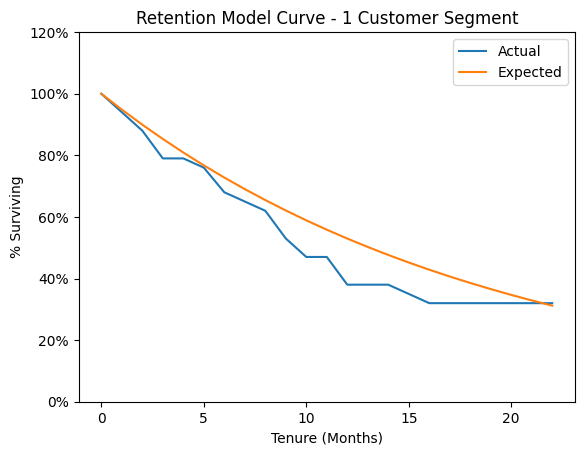

In [ ]:
plt.plot(month, retention, label="Actual")
plt.plot(month, np.ones_like(retention) * (res.x**month), label="Expected")
plt.title('Retention Model Curve - 1 Customer Segment')
plt.xlabel("Tenure (Months)")
plt.ylabel("% Surviving")
plt.ylim((0,1.2))
plt.legend()
plt.gca().yaxis.set_major_formatter(PercentFormatter(1))

#### 2 Customer Segments - Geometric Curve Fitting with Retention Rate & Segment Proportion Parameters

In [ ]:
# Observed retention curve
retention = alive/alive[0]
# Monthly loss
loss = alive[:-1] - alive[1:]

In [ ]:
def square_error(x):
    e_retention = (np.ones_like(retention) * (x[0]**month) * x[2]) + \
                  (np.ones_like(retention) * (x[1]**month) * (1 - x[2]))
    e_churn = e_retention[:-1] - e_retention[1:] 
    en_loss = e_churn * alive[0] 
    loss_error = np.sum((en_loss - loss)**2) 
    survivor_error = ((e_retention[-1] * alive[0]) - alive[-1])**2
    return loss_error + survivor_error

# 3 Decision Variables: Retention rate for segment 1 & 2 and proportion of segment 1 customers
guesses = 0.95, 0.90, 0.20
bnds = ((0, 1), (0, 1), (0, 1))
res = minimize(square_error, x0=guesses, bounds=bnds) 
print('Monthly Retention Rate - Segment 1 =', f'{res.x[0]:0.2%}')
print('% of Customer - Segment 1 =', f'{res.x[2]:0.2%}')
print('Monthly Retention Rate - Segment 2 =', f'{res.x[1]:0.2%}')
print('% of Customer - Segment 2 =', f'{1 - res.x[2]:0.2%}')
print('Sum of Squared Errors =', f'{res.fun:0.0f}')

res

Monthly Retention Rate - Segment 1 = 100.00%
% of Customer - Segment 1 = 21.00%
Monthly Retention Rate - Segment 2 = 91.39%
% of Customer - Segment 2 = 79.00%
Sum of Squared Errors = 252951531


  message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  success: True
   status: 0
      fun: 252951531.1289717
        x: [ 1.000e+00  9.139e-01  2.100e-01]
      nit: 20
      jac: [-1.521e+08 -2.224e+04 -6.858e+03]
     nfev: 104
     njev: 26
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>

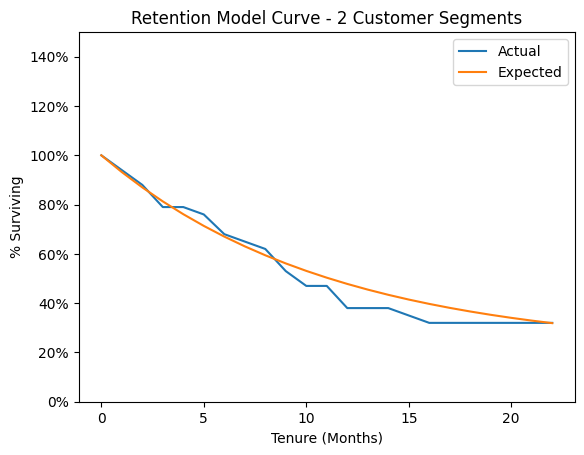

In [ ]:
e_retention = (np.ones_like(retention) * (res.x[0]**month) * res.x[2]) + \
                (np.ones_like(retention) * (res.x[1]**month) * (1 - res.x[2]))
                
plt.plot(month, retention, label="Actual")
plt.plot(month, e_retention, label="Expected")
plt.title('Retention Model Curve - 2 Customer Segments')
plt.xlabel("Tenure (Months)")
plt.ylabel("% Surviving")
plt.ylim((0,1.5))
plt.legend()
plt.gca().yaxis.set_major_formatter(PercentFormatter(1))

#### 3 Customer Segments - Geometric Curve Fitting with Retention Rate & Segment Proportion Parameters

In [ ]:
# Observed retention curve
retention = alive/alive[0]
# Monthly loss
loss = alive[:-1] - alive[1:]

In [ ]:
from scipy.optimize import LinearConstraint

def square_error(x):
    e_retention = (np.ones_like(retention) * (x[0]**month) * x[3]) + \
                  (np.ones_like(retention) * (x[1]**month) * x[4]) + \
                  (np.ones_like(retention) * (x[2]**month) * x[5])
    e_churn = e_retention[:-1] - e_retention[1:] 
    en_loss = e_churn * alive[0] 
    loss_error = np.sum((en_loss - loss)**2) 
    survivor_error = ((e_retention[-1] * alive[0]) - alive[-1])**2
    return loss_error + survivor_error

guesses = np.array([0.90, 0.90, 0.90, 0.20, 0.30, 0.50])
bnds = np.array([(0, 1), (0, 1), (0, 1), (0, 1), (0, 1), (0, 1)])
cons = LinearConstraint([0, 0, 0, 1, 1, 1], 1, 1) # Define the constraint: x[3] + x[4] + x[5] == 1
res = minimize(square_error, x0=guesses, bounds=bnds, constraints=[cons], method='trust-constr') 
print('Monthly Retention Rate - Segment 1 =', f'{res.x[0]:0.2%}')
print('% of Customer - Segment 1 =', f'{res.x[3]:0.2%}')
print('Monthly Retention Rate - Segment 2 =', f'{res.x[1]:0.2%}')
print('% of Customer - Segment 2 =', f'{res.x[4]:0.2%}')
print('Monthly Retention Rate - Segment 3 =', f'{res.x[2]:0.2%}')
print('% of Customer - Segment 3 =', f'{res.x[5]:0.2%}')
print('Sum of Squared Errors =', f'{res.fun:0.0f}')

Monthly Retention Rate - Segment 1 = 91.39%
% of Customer - Segment 1 = 37.10%
Monthly Retention Rate - Segment 2 = 100.00%
% of Customer - Segment 2 = 21.00%
Monthly Retention Rate - Segment 3 = 91.39%
% of Customer - Segment 3 = 41.89%
Sum of Squared Errors = 252951531


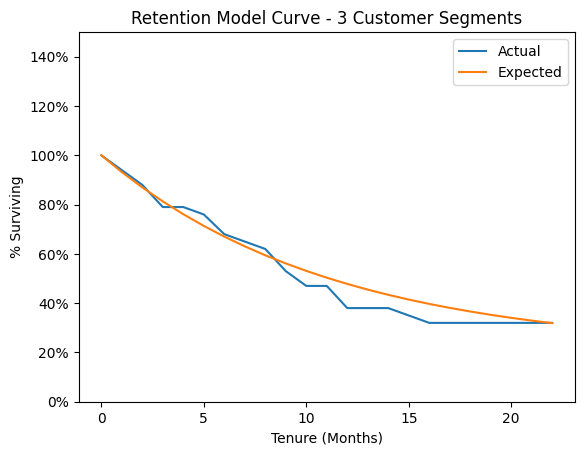

In [ ]:
e_retention = (np.ones_like(retention) * (res.x[0]**month) * res.x[3]) + \
              (np.ones_like(retention) * (res.x[1]**month) * res.x[4]) + \
              (np.ones_like(retention) * (res.x[2]**month) * res.x[5])
                
plt.plot(month, retention, label="Actual")
plt.plot(month, e_retention, label="Expected")
plt.title('Retention Model Curve - 3 Customer Segments')
plt.xlabel("Tenure (Months)")
plt.ylabel("% Surviving")
plt.ylim((0,1.5))
plt.legend()
plt.gca().yaxis.set_major_formatter(PercentFormatter(1))

In [ ]:
from scipy.optimize import LinearConstraint

def square_error(x):
    e_retention = (np.ones_like(retention) * (x[0]**month) * x[3]) + \
                  (np.ones_like(retention) * (x[1]**month) * x[4]) + \
                  (np.ones_like(retention) * (x[2]**month) * (1-x[4]-x[3]))
    e_churn = e_retention[:-1] - e_retention[1:] 
    en_loss = e_churn * alive[0] 
    loss_error = np.sum((en_loss - loss)**2) 
    survivor_error = ((e_retention[-1] * alive[0]) - alive[-1])**2
    return loss_error + survivor_error

guesses = np.array([0.90, 0.90, 0.90, 0.20, 0.30])
bnds = np.array([(0, 1), (0, 1), (0, 1), (0, 1), (0, 1)])
cons = LinearConstraint([0, 0, 0, 1, 1], 1, 1)
res = minimize(square_error, x0=guesses, bounds=bnds, constraints=[cons], method='COBYQA') 
print('Monthly Retention Rate - Segment 1 =', f'{res.x[0]:0.2%}')
print('% of Customer - Segment 1 =', f'{res.x[3]:0.2%}')
print('Monthly Retention Rate - Segment 2 =', f'{res.x[1]:0.2%}')
print('% of Customer - Segment 2 =', f'{res.x[4]:0.2%}')
print('Monthly Retention Rate - Segment 3 =', f'{res.x[2]:0.2%}')
print('% of Customer - Segment 3 =', f'{1-res.x[4]-res.x[3]:0.2%}')
print('Sum of Squared Errors =', f'{res.fun:0.0f}')

Monthly Retention Rate - Segment 1 = 100.00%
% of Customer - Segment 1 = 21.00%
Monthly Retention Rate - Segment 2 = 91.39%
% of Customer - Segment 2 = 79.00%
Monthly Retention Rate - Segment 3 = 48.15%
% of Customer - Segment 3 = 0.00%
Sum of Squared Errors = 252951531


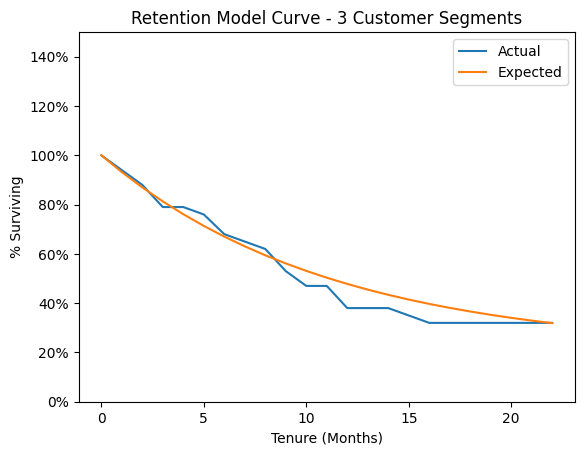

In [ ]:
e_retention = (np.ones_like(retention) * (res.x[0]**month) * res.x[3]) + \
              (np.ones_like(retention) * (res.x[1]**month) * res.x[4]) + \
              (np.ones_like(retention) * (res.x[2]**month) * (1-res.x[4]-res.x[3]))
                
plt.plot(month, retention, label="Actual")
plt.plot(month, e_retention, label="Expected")
plt.title('Retention Model Curve - 3 Customer Segments')
plt.xlabel("Tenure (Months)")
plt.ylabel("% Surviving")
plt.ylim((0,1.5))
plt.legend()
plt.gca().yaxis.set_major_formatter(PercentFormatter(1))

#### 1 Customer Segment - Exponential Curve Fitting with Churn Parameter

In [ ]:
month, alive = np.loadtxt('data/DSC-retention-data.csv', dtype='object', delimiter=',', unpack=True, skiprows=1) 
month = month.astype(int)
alive = alive.astype(float)

train_month = month[:8]
train_alive = alive[:8]

In [ ]:
def square_error(theta):
    retention = train_alive / train_alive[0]
    e_retention = (1-theta)**train_month
    return np.sum((retention-e_retention)**2)

theta_guess = 0.5
res = minimize(square_error, theta_guess, bounds=[(0.000001,0.999999)])
theta = res.x[0]
print(f'{theta = :.1%}')
print(f'retention rate = {1-theta:.1%}')
print(f'SSE = {res.fun:.3%}')

theta = 11.2%
retention rate = 88.8%
SSE = 0.929%


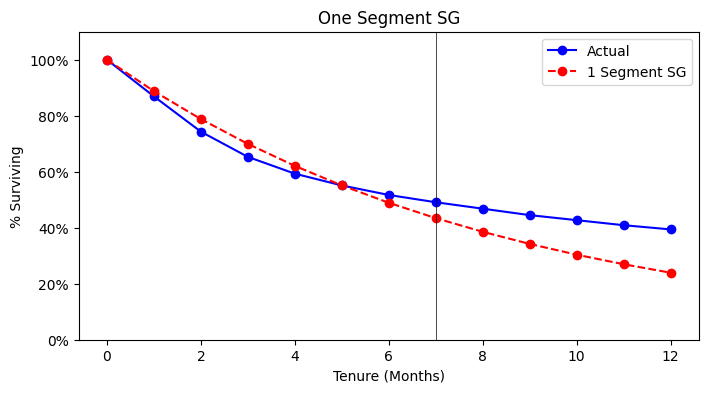

In [ ]:
train_marker_x = [7 for _ in np.arange(0,1.2,0.1)]
train_marker_y = [_ for _ in np.arange(0,1.2,0.1)]

retention = alive / alive[0]
e_retention = (1-theta)**month

plt.figure(figsize=(8,4), dpi=100)
plt.plot(retention, "b-o", label='Actual')
plt.plot(e_retention, "r--o", label='1 Segment SG')
plt.plot(train_marker_x, train_marker_y, "k-", linewidth=0.5)
plt.title('One Segment SG')
plt.xlabel("Tenure (Months)")
plt.ylabel("% Surviving")
plt.ylim(0,1.1)
plt.legend()
plt.gca().yaxis.set_major_formatter(PercentFormatter(1))

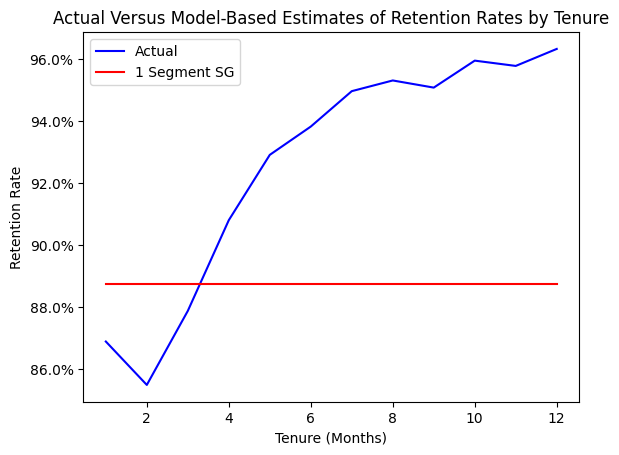

In [ ]:
rr = alive[1:] / alive[:-1]
e_alive = alive[0] * e_retention
e_rr = e_alive[1:] / e_alive[:-1]

plt.title("Actual Versus Model-Based Estimates of Retention Rates by Tenure")
plt.plot(month[1:], rr, "b", label='Actual')
plt.plot(month[1:], e_rr, "r", label='1 Segment SG')
plt.xlabel("Tenure (Months)")
plt.ylabel("Retention Rate")
plt.legend()
plt.gca().yaxis.set_major_formatter(PercentFormatter(1))

#### 2 Customer Segments - Exponential Curve Fitting with Churn & Segment Proportion Parameter

In [ ]:
def square_error(x):
    retention = train_alive / train_alive[0]
    s1_retention = (1-x[1])**train_month
    s2_retention = (1-x[2])**train_month
    e_retention = s1_retention*x[0] + s2_retention*(1-x[0])
    return np.sum((retention-e_retention)**2)

guesses = [0.2, 0.1, 0.1]
bnd = [(0,1), (0,1), (0,1)]
res = minimize(square_error, guesses, bounds=bnd)

pi1, theta1, theta2 = res.x
print(f'{pi1 = :.1%}, {theta1 = :.1%}, rr = {1-theta1:.1%}\npi2 = {1-pi1:.1%}, {theta2 = :.1%}, rr = {1-theta2:.1%}')
print(f'SSE = {res.fun:.3%}')

pi1 = 40.6%, theta1 = 0.0%, rr = 100.0%
pi2 = 59.4%, theta2 = 24.6%, rr = 75.4%
SSE = 0.032%


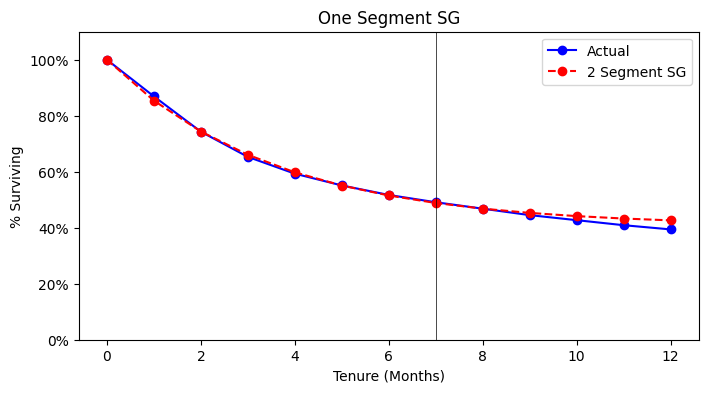

In [ ]:
train_marker_x = [7 for _ in np.arange(0,1.2,0.1)]
train_marker_y = [_ for _ in np.arange(0,1.2,0.1)]

retention = alive / alive[0]
s1_retention = (1-theta1)**month
s2_retention = (1-theta2)**month
e_retention = s1_retention*pi1 + s2_retention*(1-pi1)

plt.figure(figsize=(8,4), dpi=100)
plt.plot(retention, "b-o", label='Actual')
plt.plot(e_retention, "r--o", label='2 Segment SG')
plt.plot(train_marker_x, train_marker_y, "k-", linewidth=0.5)
plt.title('One Segment SG')
plt.xlabel("Tenure (Months)")
plt.ylabel("% Surviving")
plt.ylim(0,1.1)
plt.legend()
plt.gca().yaxis.set_major_formatter(PercentFormatter(1))

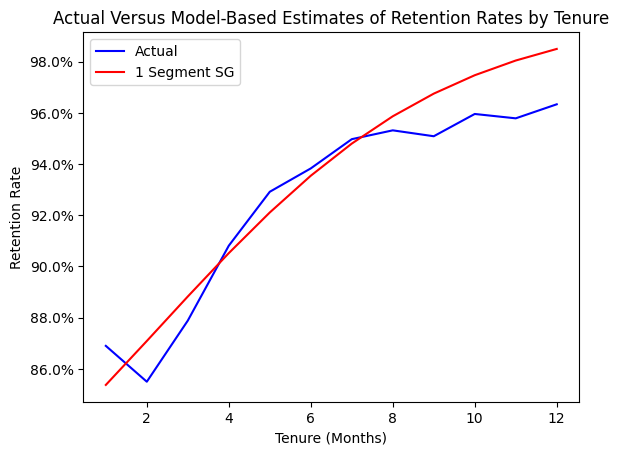

In [ ]:
rr = alive[1:] / alive[:-1]
e_alive = alive[0] * e_retention
e_rr = e_alive[1:] / e_alive[:-1]

plt.title("Actual Versus Model-Based Estimates of Retention Rates by Tenure")
plt.plot(month[1:], rr, "b", label='Actual')
plt.plot(month[1:], e_rr, "r", label='1 Segment SG')
plt.xlabel("Tenure (Months)")
plt.ylabel("Retention Rate")
plt.legend()
plt.gca().yaxis.set_major_formatter(PercentFormatter(1))

#### Problem with Parametric Approach

The fit of all models up to and including Year 7 is reasonable, and the 2 segment geometric model provides a particularly good fit. But when we consider the projections beyond the model calibration period, all models break down dramatically with the 1 segment geometric function underestimating percentage survival while the 2 segment geometric function overestimating survival. This range of error may not be acceptable in most cases.

We need to look towards other probabilistic models of the survival function (or contract duration) that are based on a simple story of customer behavior. 

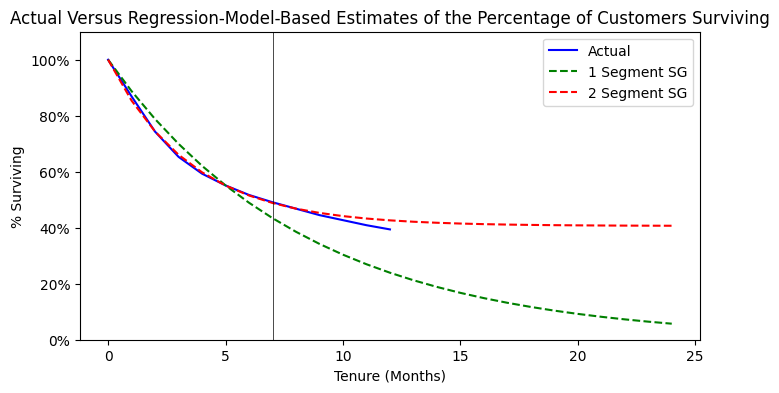

In [ ]:
train_marker_x = [7 for _ in np.arange(0,1.2,0.1)]
train_marker_y = [_ for _ in np.arange(0,1.2,0.1)]

retention = alive / alive[0]
x_month = np.arange(0, 25, 1)

# 1 Segment SG
e_retention1 = (1-theta)**x_month

# 2 Segment SG
s1_retention = (1-theta1)**x_month
s2_retention = (1-theta2)**x_month
e_retention2 = s1_retention*pi1 + s2_retention*(1-pi1)

plt.figure(figsize=(8,4), dpi=100)
plt.plot(retention, "b-", label='Actual')
plt.plot(e_retention1, "g--", label='1 Segment SG')
plt.plot(e_retention2, "r--", label='2 Segment SG')
plt.plot(train_marker_x, train_marker_y, "k-", linewidth=0.5)
plt.title('Actual Versus Regression-Model-Based Estimates of the Percentage of Customers Surviving')
plt.xlabel("Tenure (Months)")
plt.ylabel("% Surviving")
plt.ylim(0,1.1)
plt.legend()
plt.gca().yaxis.set_major_formatter(PercentFormatter(1))

### Shifted Beta Geometric (sBG) Model 

The shifted beta geometric model (sBG) is a model that is used to forecast retention/survival of users in contractual settings (think netflix, disney plus, tinder gold, etc). The model is quite simple and posits:
- At the end of each period, a customer flips a coin: “heads” she cancels he contract, “tails” she renews it.
- For each individual, the probability of a coin coming up “heads” does not change over time
- The probability of heads varies across customers. 

The two things we need are the probability density function and the survival function. Mathematically, the probability density and survival function are:
$$P(T=t \mid \alpha, \beta) = \dfrac{B(\alpha+1, \beta+t-1)}{B(\alpha, \beta)}$$
$$S(T=t \mid \alpha, \beta) = \dfrac{B(\alpha, \beta+t)}{B(\alpha, \beta)}$$

Here, $B(\alpha, \beta)$ is the beta function and not the beta distribution.

#### Shifted-Beta-Geometric (sBG)